[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kishan2805/final-submit/blob/main/final-submission%20Qual-230331/code.ipynb)

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import gdown

import argparse
import numpy as np
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
# from keras.layers.merge import add, concatenate
from keras.layers import add, concatenate

from keras.models import Model
import struct
import cv2
from copy import deepcopy

# Prepare data
DATA_ROOT = '/content/data'
os.makedirs(DATA_ROOT, exist_ok=True)

# image_url = 'https://drive.google.com/uc?id=12ZpZ5H0kJIkWk6y4ktGfqR5OTKofL7qw'
# image_path = os.path.join(DATA_ROOT, 'image.jpg')
# gdown.download(image_url, image_path, True)
!wget -O /content/data/image.jpg "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image.jpg"

# image2_url = 'https://drive.google.com/uc?id=1_WpFbGEuS2r19UeP6wekbcF0kb-0nH18'
# image2_path = os.path.join(DATA_ROOT, 'image2.jpg')
# gdown.download(image2_url, image2_path, True)
!wget -O /content/data/image2.jpg "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image2.jpg"

# video_url = 'https://drive.google.com/uc?id=1xFGjpzhZVYtNor9hJevvxysGESZJIMDz'
# video_path = os.path.join(DATA_ROOT, 'video1.mp4')
# gdown.download(video_url, video_path, True)
!wget -O /content/data/video1.mp4 "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/6.mp4"

# model_url = 'https://drive.google.com/uc?id=19XKJWMKDfDlag2MR8ofjwvxhtr9BxqqN'
model_path = os.path.join(DATA_ROOT, 'yolo_weights.h5')
# gdown.download(model_url, model_path, True)
!wget -O /content/data/yolo_weights.h5 "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/yolo.h5"

labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", \
              "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", \
              "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", \
              "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", \
              "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", \
              "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", \
              "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", \
              "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", \
              "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", \
              "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax

        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]

        return self.score

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])

    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

    union = w1*h1 + w2*h2 - intersect

    return float(intersect) / union

def preprocess_input(image_pil, net_h, net_w):
    image = np.asarray(image_pil)
    new_h, new_w, _ = image.shape

    # determine the new size of the image
    if (float(net_w)/new_w) < (float(net_h)/new_h):
        new_h = (new_h * net_w)/new_w
        new_w = net_w
    else:
        new_w = (new_w * net_h)/new_h
        new_h = net_h

    # resize the image to the new size
    #resized = cv2.resize(image[:,:,::-1]/255., (int(new_w), int(new_h)))
    resized = cv2.resize(image/255., (int(new_w), int(new_h)))

    # embed the image into the standard letter box
    new_image = np.ones((net_h, net_w, 3)) * 0.5
    new_image[int((net_h-new_h)//2):int((net_h+new_h)//2), int((net_w-new_w)//2):int((net_w+new_w)//2), :] = resized
    new_image = np.expand_dims(new_image, 0)

    return new_image


def decode_netout(netout_, obj_thresh, anchors_, image_h, image_w, net_h, net_w):
    netout_all = deepcopy(netout_)
    boxes_all = []
    for i in range(len(netout_all)):
      netout = netout_all[i][0]
      anchors = anchors_[i]

      grid_h, grid_w = netout.shape[:2]
      nb_box = 3
      netout = netout.reshape((grid_h, grid_w, nb_box, -1))
      nb_class = netout.shape[-1] - 5

      boxes = []

      netout[..., :2]  = _sigmoid(netout[..., :2])
      netout[..., 4:]  = _sigmoid(netout[..., 4:])
      netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
      netout[..., 5:] *= netout[..., 5:] > obj_thresh

      for i in range(grid_h*grid_w):
          row = i // grid_w
          col = i % grid_w

          for b in range(nb_box):
              # 4th element is objectness score
              objectness = netout[row][col][b][4]
              #objectness = netout[..., :4]
              # last elements are class probabilities
              classes = netout[row][col][b][5:]

              if((classes <= obj_thresh).all()): continue

              # first 4 elements are x, y, w, and h
              x, y, w, h = netout[row][col][b][:4]

              x = (col + x) / grid_w # center position, unit: image width
              y = (row + y) / grid_h # center position, unit: image height
              w = anchors[b][0] * np.exp(w) / net_w # unit: image width
              h = anchors[b][1] * np.exp(h) / net_h # unit: image height

              box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
              #box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, None, classes)

              boxes.append(box)

      boxes_all += boxes

    # Correct boxes
    boxes_all = correct_yolo_boxes(boxes_all, image_h, image_w, net_h, net_w)

    return boxes_all

def correct_yolo_boxes(boxes_, image_h, image_w, net_h, net_w):
    boxes = deepcopy(boxes_)
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h

    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h

        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
    return boxes

def do_nms(boxes_, nms_thresh, obj_thresh):
    boxes = deepcopy(boxes_)
    if len(boxes) > 0:
        num_class = len(boxes[0].classes)
    else:
        return

    for c in range(num_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

    new_boxes = []
    for box in boxes:
        label = -1

        for i in range(num_class):
            if box.classes[i] > obj_thresh:
                label = i
                # print("{}: {}, ({}, {})".format(labels[i], box.classes[i]*100, box.xmin, box.ymin))
                box.label = label
                box.score = box.classes[i]
                new_boxes.append(box)

    return new_boxes


from PIL import ImageDraw, ImageFont
import colorsys

def draw_boxes(image_, boxes, labels):
    image = image_.copy()
    image_w, image_h = image.size
    font = ImageFont.truetype(font='/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf',
                    size=np.floor(3e-2 * image_h + 0.5).astype('int32'))
    thickness = (image_w + image_h) // 300

    # Generate colors for drawing bounding boxes.
    hsv_tuples = [(x / len(labels), 1., 1.)
                  for x in range(len(labels))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(
        map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    np.random.seed(10101)  # Fixed seed for consistent colors across runs.
    np.random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    np.random.seed(None)  # Reset seed to default.

    for i, box in reversed(list(enumerate(boxes))):
        c = box.get_label()
        predicted_class = labels[c]
        score = box.get_score()
        top, left, bottom, right = box.ymin, box.xmin, box.ymax, box.xmax

        label = '{} {:.2f}'.format(predicted_class, score)
        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)
        #label_size = draw.textsize(label)

        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image_h, np.floor(bottom + 0.5).astype('int32'))
        right = min(image_w, np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i],
                outline=colors[c])
        draw.rectangle(
            [tuple(text_origin), tuple(text_origin + label_size)],
            fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        #draw.text(text_origin, label, fill=(0, 0, 0))
        del draw
    return image

--2024-11-18 10:37:44--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94721 (93K) [image/jpeg]
Saving to: ‘/content/data/image.jpg’

/content/data/image 100%[===================>]  92.50K   387KB/s    in 0.2s    

2024-11-18 10:37:44 (387 KB/s) - ‘/content/data/image.jpg’ saved [94721/94721]

--2024-11-18 10:37:44--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image2.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 1

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#pre-defined bounding boxes tailored based on object shapes in training dataset(9 boxes in total divided into 3 grps since detection is performed on 3 scales)
anchors = [[[116,90], [156,198], [373,326]], [[30,61], [62,45], [59,119]], [[10,13], [16,30], [33,23]]]

The type of the saved image is <class 'PIL.JpegImagePlugin.JpegImageFile'>


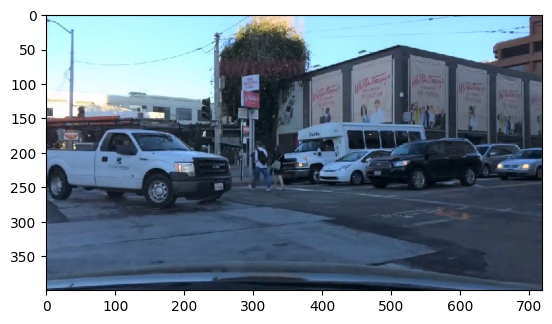

(400, 720)


In [ ]:
#loading image to apply object detection on
from PIL import Image
from matplotlib import  pyplot as plt

image_path = '/content/data/image.jpg'

image_pil = Image.open(image_path)
image_w, image_h = image_pil.size #(access both properties at same time)
img_width = image_pil.width
img_height = image_pil.height
print("The type of the saved image is {}".format(type(image_pil)))
plt.imshow(image_pil)
plt.show()
print(f'{(img_height, img_width)}') # height = 400, width = 720

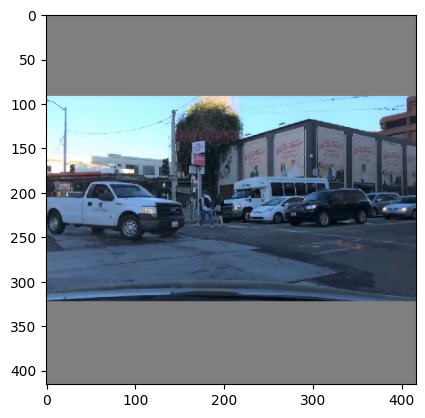

(1, 416, 416, 3)


In [ ]:
# pre-processing image into specific size so that it can be fed into the darknet model
net_h = 416
net_w = 416

new_image = preprocess_input(image_pil, net_h, net_w)
plt.imshow(new_image[0])
plt.show()
print(new_image.shape) # 1 image, 416 x 416 and 3 color channels

In [ ]:
import tensorflow as tf

# Load model
darknet = tf.keras.models.load_model(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
# completing forward pass on pre-processed image
yolo_outputs = darknet.predict(new_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [ ]:
print(yolo_outputs[0])
print(yolo_outputs[1])
print(yolo_outputs[2])

[[[[ 3.81984174e-01 -7.87799358e-01 -2.92652905e-01 ... -9.67034245e+00
    -8.83585739e+00 -9.44118309e+00]
   [ 1.89616883e+00  5.33377051e-01  3.45836848e-01 ... -9.00106049e+00
    -9.32204628e+00 -1.09133644e+01]
   [-1.13591659e+00  1.20013368e+00  2.48576313e-01 ... -8.48965168e+00
    -7.85491896e+00 -8.13602257e+00]
   ...
   [ 3.77151966e-01  8.32843900e-01 -1.43882960e-01 ... -8.37658119e+00
    -9.25674629e+00 -1.05445719e+01]
   [-4.24743950e-01  9.10696030e-01 -1.91601336e-01 ... -6.67084169e+00
    -8.37290955e+00 -8.03934956e+00]
   [-2.08179784e+00  1.12545776e+00  2.67017365e-01 ... -5.05082941e+00
    -6.69841623e+00 -5.93453360e+00]]

  [[ 9.47687805e-01  3.07830393e-01 -3.43244761e-01 ... -9.92442513e+00
    -9.06333256e+00 -9.84261703e+00]
   [ 2.40706101e-01  4.78483021e-01  1.06343105e-01 ... -1.02372532e+01
    -9.70267963e+00 -1.11462021e+01]
   [-1.00406551e+00 -5.25935054e-01 -9.76510346e-03 ... -9.70499039e+00
    -9.39340305e+00 -1.08703222e+01]
   ...
   

In [ ]:
print(yolo_outputs[0].shape)
print(yolo_outputs[1].shape)
print(yolo_outputs[2].shape)

(1, 13, 13, 255)
(1, 26, 26, 255)
(1, 52, 52, 255)


In [ ]:
# !pip uninstall pillow
# !pip install pillow==8.4.0

car 1.00 (653, 189) (720, 243)
person 0.88 (325, 189) (348, 258)
person 0.94 (297, 185) (328, 253)
car 0.99 (625, 187) (688, 233)
traffic light 0.45 (224, 123) (239, 153)
car 0.98 (462, 180) (635, 257)
car 0.47 (375, 181) (534, 243)
bus 0.91 (353, 153) (554, 233)
truck 0.95 (0, 161) (268, 278)


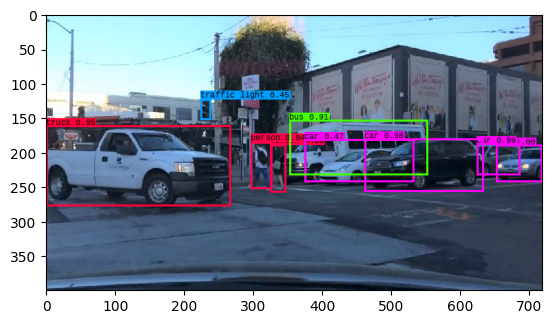

In [ ]:
# post-processing for bounding box prediction(threshold is applied to filter out bounding boxes model is confident of)
obj_thresh = 0.4
nms_thresh = 0.45

boxes = decode_netout(yolo_outputs, obj_thresh, anchors, image_h, image_w, net_h, net_w) # returns boxes with value > objectness thresh
boxes = do_nms(boxes, nms_thresh, obj_thresh) # removes boxes with big overlap on other boxes
final_image = draw_boxes(image_pil, boxes, labels) # draws bounding box around image
plt.imshow(final_image)
plt.show()

person 0.53 (325, 203) (348, 256)
car 0.96 (666, 191) (720, 241)
car 1.00 (653, 189) (720, 243)
car 0.85 (624, 190) (685, 239)
person 0.88 (325, 189) (348, 258)
person 0.94 (297, 185) (328, 253)
car 0.90 (650, 187) (720, 237)
car 0.99 (625, 187) (688, 233)
car 0.67 (618, 189) (678, 233)
traffic light 0.45 (224, 123) (239, 153)
car 0.59 (632, 186) (720, 238)
car 0.45 (614, 185) (697, 234)
car 0.95 (478, 180) (635, 255)
car 0.98 (462, 180) (635, 257)
car 0.47 (375, 181) (534, 243)
person 0.48 (296, 183) (342, 258)
bus 0.91 (353, 153) (554, 233)
bus 0.48 (339, 156) (537, 232)
truck 0.85 (0, 173) (274, 285)
bus 0.82 (345, 144) (571, 237)
bus 0.42 (326, 146) (547, 239)
truck 0.95 (0, 161) (268, 278)


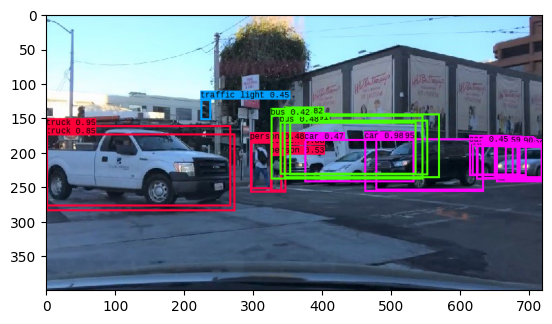

In [ ]:
# using non-maximal suppression to visualize # of bounding boxes after each step

boxes = decode_netout(yolo_outputs, obj_thresh, anchors, image_h, image_w, net_h, net_w)
# boxes = do_nms(boxes, nms_thresh, obj_thresh) # removes boxes w highest probability in an adjacent overlap
final_image = draw_boxes(image_pil, boxes, labels)
plt.imshow(final_image)
plt.show()
# since do_nms function isn't implemented, extraneous boxes with big overlap exist in image and aren't removed

In [ ]:
#combining pre-procssed image with the post-processing steps to get final bounding box predictions

def detect_image(image_pil, obj_thresh = 0.35, nms_thresh = 0.45, darknet=darknet, net_h=416, net_w=416, anchors=anchors, labels=labels):

  new_image = preprocess_input(image_pil, net_h, net_w)
  yolo_outputs = darknet.predict(new_image)
  boxes = decode_netout(yolo_outputs, obj_thresh, anchors, image_pil.height, image_pil.width, net_h, net_w) # so that it works with any image
  boxes = do_nms(boxes, nms_thresh, obj_thresh)
  final_image = draw_boxes(image_pil, boxes, labels)
  return final_image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
car 1.00 (653, 189) (720, 243)
person 0.88 (325, 189) (348, 258)
person 0.94 (297, 185) (328, 253)
car 0.99 (625, 187) (688, 233)
traffic light 0.45 (224, 123) (239, 153)
car 0.98 (462, 180) (635, 257)
car 0.47 (375, 181) (534, 243)
bus 0.91 (353, 153) (554, 233)
truck 0.95 (0, 161) (268, 278)


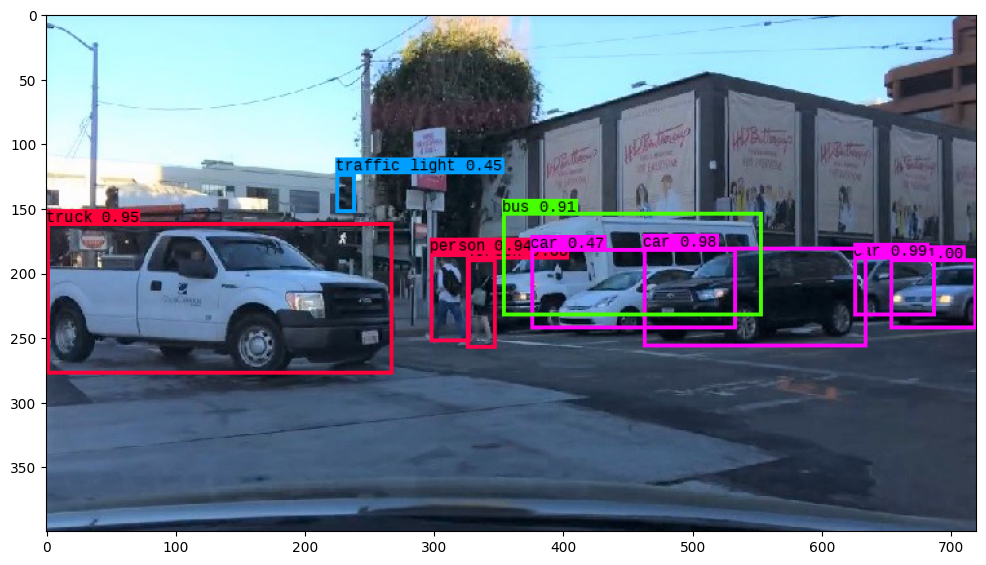

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(detect_image(image_pil))
plt.show()

In [ ]:
# extending image detection algorithm to videos
import cv2

def detect_video(video_path, output_path, obj_thresh = 0.35, nms_thresh = 0.45, darknet=darknet, net_h=416, net_w=416, anchors=anchors, labels=labels):
    vid = cv2.VideoCapture(video_path)
    if not vid.isOpened():
        raise IOError("Couldn't open webcam or video")
    video_FourCC    = int(vid.get(cv2.CAP_PROP_FOURCC))
    video_FourCC = cv2.VideoWriter_fourcc(*'mp4v')
    video_fps       = vid.get(cv2.CAP_PROP_FPS)
    video_size      = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),
                        int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))

    out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)

    num_frame = 0
    while vid.isOpened():
      ret, frame = vid.read()
      num_frame += 1
      print("=== Frame {} ===".format(num_frame))
      if ret:
          new_frame = frame
          image_pil = Image.fromarray(cv2.cvtColor(new_frame, cv2.COLOR_BGR2RGB)) # convert cv2 to pil for detection
          new_image_pil = detect_image(image_pil)
          new_frame = cv2.cvtColor(np.asarray(new_image_pil), cv2.COLOR_RGB2BGR) # back to cv2 so frames fed into input video
          out.write(new_frame)
      else:
          break
    vid.release()
    out.release()
    print("New video saved!")

In [ ]:
# testing algorithm on custom video
video_path = '/content/data/vid2.mp4'
output_path = '/content/data/night.mp4'
detect_video(video_path, output_path)

Streaming output truncated to the last 5000 lines.
car 0.48 (422, 151) (479, 199)
car 0.94 (575, 140) (640, 183)
person 0.53 (513, 128) (527, 149)
motorbike 0.94 (531, 217) (590, 304)
motorbike 0.70 (152, 217) (257, 307)
person 0.59 (158, 171) (249, 307)
motorbike 0.37 (109, 209) (174, 270)
person 0.56 (433, 182) (479, 247)
car 0.83 (487, 155) (571, 236)
truck 0.45 (341, 150) (422, 226)
truck 0.45 (341, 150) (422, 226)
car 0.88 (2, 150) (109, 238)
=== Frame 81 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
motorbike 0.61 (436, 196) (484, 249)
person 0.36 (449, 161) (477, 208)
car 0.42 (419, 152) (478, 196)
car 0.89 (575, 141) (639, 183)
person 0.56 (512, 128) (527, 149)
motorbike 0.94 (531, 218) (587, 304)
motorbike 0.54 (136, 223) (231, 309)
person 0.39 (140, 173) (233, 309)
person 0.64 (432, 180) (479, 247)
car 0.82 (486, 152) (572, 240)
truck 0.50 (337, 149) (419, 226)
truck 0.50 (337, 149) (419, 226)
car 0.79 (2, 152) (111, 238)
=== Frame 82 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
mot

In [ ]:
from IPython.display import display, Javascript, clear_output
from google.colab.output import eval_js
from PIL import Image
import cv2
import numpy as np
import io
import base64

def capture_webcam_snapshot():
    js = Javascript('''
    async function captureSnapshot() {
        const video = document.createElement('video');
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        video.srcObject = stream;
        await video.play();

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);

        stream.getTracks().forEach(track => track.stop());
        return canvas.toDataURL('image/jpeg');
    }
    ''')
    display(js)
    data_url = eval_js('captureSnapshot()')
    return data_url

def data_url_to_image(data_url):
    # Convert base64 image data to a PIL Image
    header, encoded = data_url.split(',', 1)
    data = base64.b64decode(encoded)
    image = Image.open(io.BytesIO(data))
    return image

def detect_webcam_colab(obj_thresh=0.35, nms_thresh=0.45, darknet=darknet, net_h=416, net_w=416, anchors=anchors, labels=labels):
    try:
        while True:
            # Capture snapshot from webcam
            data_url = capture_webcam_snapshot()
            frame = data_url_to_image(data_url)

            # Process the frame with your detection model
            processed_frame = detect_image(frame, obj_thresh, nms_thresh, darknet, net_h, net_w, anchors, labels)

            # Clear previous output and display the new frame
            clear_output(wait=True)
            display(processed_frame)

    except KeyboardInterrupt:
        print("Stopped.")


In [ ]:
import base64


In [ ]:
detect_webcam_colab()
